In [1]:
import scanpy as sc
import anndata as ann
import loompy as lo
import numpy as np 
import glob
import seaborn as sb
import pandas as pd
import scrublet as scr
import pickle

sc.settings.verbosity = 3

from matplotlib import rcParams
import matplotlib.pyplot as plt

import sys  
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/mm_pancreas_atlas_rep/code/')
import helper as h
from constants import SAVE

#R interface
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import anndata2ri

rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [2]:
%%R
library(scran)
library(RColorBrewer)
library(DropletUtils)
library(BiocParallel)

In [3]:
# Path for saving results - last shared folder by all datasets
shared_folder='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/'
#Path for loading individual samples
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC136*/'
#Unique ID2 for reading/writing h5ad files with helper function
UID2='VSG_nonref_pp'

## Load data (filtered)

In [4]:
# Load metadata for the project
metadata=pd.read_excel('/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/scRNA-seq_pancreas_metadata.xlsx',
             sheet_name='VSG')

In [5]:
# Find samples used for reference
samples=metadata.query(' tissue == "islet"')
print('Selectede islet samples:')
print(samples)

Selectede islet samples:
  sample_name tissue   strain        design condition              metadata  \
0    MUC13631  islet  Lepr-/-    PF_Lepr-/-        PF     Islets_983_Hom_PF   
1    MUC13632  islet  Lepr-/-    PF_Lepr-/-        PF    Islets_1513_Hom_PF   
2    MUC13633  islet       WT       chow_WT      chow  Islets_942-1_WT_Chow   
3    MUC13634  islet       WT       chow_WT      chow  Islets_937-8_WT_Chow   
4    MUC13639  islet  Lepr-/-  sham_Lepr-/-      sham   Islets_539_Hom_Sham   
5    MUC13640  islet  Lepr-/-   VSG_Lepr-/-       VSG   Islets_1518_Hom_VSG   
6    MUC13641  islet  Lepr-/-  sham_Lepr-/-      sham   Islets_768_Hom_Sham   
7    MUC13642  islet  Lepr-/-   VSG_Lepr-/-       VSG   Islets_1137_Hom_VSG   

     technique  for_reference   age   sex  internal_id  
0  Chromium v3          False  20 w  male          265  
1  Chromium v3          False  20 w  male          266  
2  Chromium v3           True  20 w  male          267  
3  Chromium v3           True  20 w

NOTE: The age was latter corrected in accordance to more detailed updated metadata table, thus the displayed age does not match the real age.

In [7]:
# List all files
file_name='filtered_feature_bc_matrix.h5ad'
files=glob.glob(path_data+file_name)
# Find which parts of file paths differ between files to later use them as file id
diff_path_idx=[]
for position in range(len(path_data.split('/'))):
    values=set([file.split('/')[position] for file in files])
    if len(values)>1:
        diff_path_idx.append(position)

In [8]:
# Subset to files used for reference
files_subset=[]
for file in files:
    sample='_'.join([file.split('/')[i] for i in diff_path_idx])
    if any(sample_name in sample for sample_name in samples.sample_name.values):
        files_subset.append(file)
print('Selected sample files:')
print(files_subset)

Selected sample files:
['/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13640/filtered_feature_bc_matrix.h5ad', '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13639/filtered_feature_bc_matrix.h5ad', '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13633/filtered_feature_bc_matrix.h5ad', '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13634/filtered_feature_bc_matrix.h5ad', '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13641/filtered_feature_bc_matrix.h5ad', '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13631/filtered_feature_bc_matrix.h5ad', '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnDa

In [9]:
# Load files and extract parts of file path that identifies the file, compared to other loaded files
adatas=[]
file_diffs=[]
for file in files_subset:
    print('Reading file',file)
    #adatas.append(sc.read_h5ad(file))
    adatas.append(h.open_h5ad(file=file,unique_id2=UID2))
    file_diffs.append('_'.join([file.split('/')[i] for i in diff_path_idx]))
    
adata = ann.AnnData.concatenate( *adatas,  batch_key = 'file', batch_categories = file_diffs).copy()    

Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13640/filtered_feature_bc_matrix.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13639/filtered_feature_bc_matrix.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13633/filtered_feature_bc_matrix.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13634/filtered_feature_bc_matrix.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13641/filtered_feature_bc_matrix.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13631/filtered_feature_bc_matrix.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/p

In [11]:
# Sample names
file_diffs

['MUC13640',
 'MUC13639',
 'MUC13633',
 'MUC13634',
 'MUC13641',
 'MUC13631',
 'MUC13642',
 'MUC13632']

In [12]:
adata

AnnData object with n_obs × n_vars = 90144 × 31125
    obs: 'file'

In [13]:
# Add file annotation if single sample is present so that below code works
if len(file_diffs)==1:
    adata.obs['file']=file_diffs[0]

## Empty droplets and ambient gene expression

### Check that empty droplets were removed

N counts for cells that passed CellRanger filtering

In [14]:
# Visually check if empty cells are present
adata.obs['n_counts'] = adata.X.sum(axis = 1)

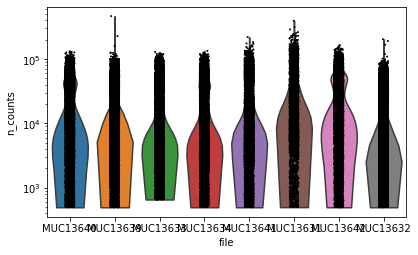

In [15]:
t1 = sc.pl.violin(adata, 'n_counts',
                  groupby='file',
                  size=2, log=True, cut=0)

In [6]:
# Load raw data
# List all files
file_name='raw_feature_bc_matrix.h5ad'
files=glob.glob(path_data+file_name)
# Find which parts of file paths differ between files to later use them as file id
diff_path_idx=[]
for position in range(len(path_data.split('/'))):
    values=set([file.split('/')[position] for file in files])
    if len(values)>1:
        diff_path_idx.append(position)

In [7]:
# Subset to files used for reference
files_subset=[]
for file in files:
    sample='_'.join([file.split('/')[i] for i in diff_path_idx])
    if any(sample_name in sample for sample_name in samples.sample_name.values):
        files_subset.append(file)
print('Reference sample files:')
print(files_subset)

Reference sample files:
['/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13640/raw_feature_bc_matrix.h5ad', '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13639/raw_feature_bc_matrix.h5ad', '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13633/raw_feature_bc_matrix.h5ad', '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13634/raw_feature_bc_matrix.h5ad', '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13641/raw_feature_bc_matrix.h5ad', '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13631/raw_feature_bc_matrix.h5ad', '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13642/raw_feature_bc_ma

In [ ]:
# Load files and extract parts of file path that identifies the file, compared to other loaded files
adatas_raw=[]
file_diffs=[]
for file in files_subset:
    print('Reading file',file)
    #adatas_raw.append(sc.read_h5ad(file))
    adatas_raw.append(h.open_h5ad(file=file,unique_id2=UID2))
    file_diffs.append('_'.join([file.split('/')[i] for i in diff_path_idx]))
    
adata_raw = ann.AnnData.concatenate( *adatas_raw,  batch_key = 'file', batch_categories = file_diffs).copy()    

Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13640/raw_feature_bc_matrix.h5ad


In [ ]:
adata_raw

In [ ]:
# Add file annotation if single sample is present so that below code works
if len(file_diffs)==1:
    adata_raw.obs['file']=file_diffs[0]

In [ ]:
adata_raw.obs['n_counts'] = adata_raw.X.sum(1)

In [24]:
# Find drops removed by CellRanger
filtered_drops=~adata_raw.obs.index.isin(adata.obs.index)
print('N drops filtered out as empty:',filtered_drops.sum(),
      'out of all drops:',adata_raw.shape[0],'-> remaining:',adata.shape[0])

N drops filtered out as empty: 54268896 out of all drops: 54359040 -> remaining: 90144


Distribution of N counts of drops that were removed by CellRanger

Trying to set attribute `.uns` of view, copying.


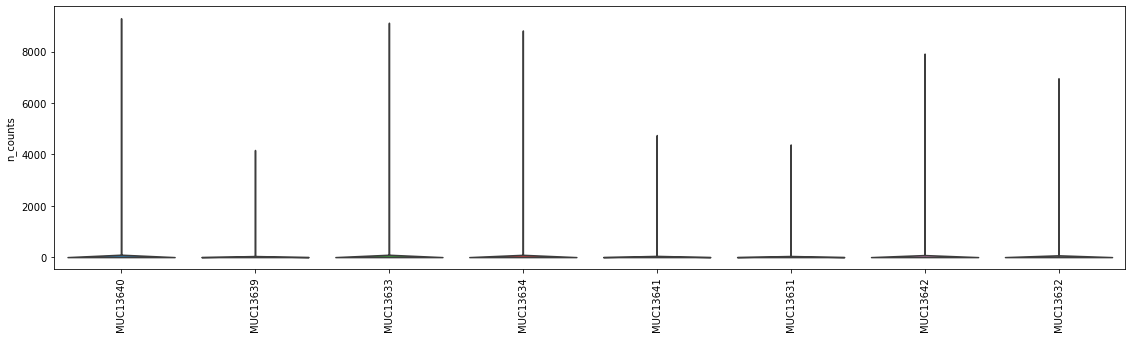

In [25]:
# Plot n_counts of drops that were removed by CellRanger
rcParams['figure.figsize']= (15,5)
sc.pl.violin(adata_raw[filtered_drops], ['n_counts'], groupby='file', size=1, log=False,rotation=90,stripplot=False)

In [26]:
#print('N cells per non-filtered sample')
#adata_raw.obs['file'].value_counts()

In [ ]:
#Remove empty genes and cells
sc.pp.filter_cells(adata_raw, min_counts=1)
sc.pp.filter_genes(adata_raw, min_cells=1)

In [15]:
adata_raw

AnnData object with n_obs × n_vars = 18251305 × 25714
    obs: 'file', 'n_counts'
    var: 'n_cells'

Cell N counts sorted by cell N counts rank without all 0 cells. 

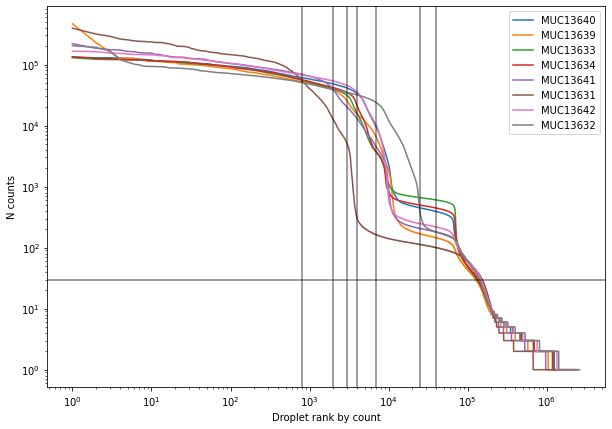

In [38]:
# For each file plot N count vs cell rank by count with log axes
rcParams['figure.figsize']= (10,7)
fig, ax=plt.subplots()
for file in adata_raw.obs.file.unique():
    adata_raw_sub=adata_raw[adata_raw.obs.file==file,:].copy()
    plt.plot(list(range(1,adata_raw_sub.shape[0]+1)),adata_raw_sub.obs.n_counts.sort_values(ascending=False),
            label=file)
del adata_raw_sub
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Droplet rank by count')
plt.ylabel('N counts')
ax.axvline(800,c='k',alpha=0.5)
ax.axvline(2000,c='k',alpha=0.5)
ax.axvline(3000,c='k',alpha=0.5)
ax.axvline(4000,c='k',alpha=0.5)
ax.axvline(7000,c='k',alpha=0.5)
ax.axvline(25000,c='k',alpha=0.5)
ax.axvline(40000,c='k',alpha=0.5)
ax.axhline(30,c='k',alpha=0.5)

### Compute ambient genes

Compute ambient genes with emptyDrops and based on mean expression in low count droplets across all samples.

In [30]:
# Prepare data for emptyDrops
sparse_mat = adata_raw.X.T
genes = adata_raw.var_names
barcodes = adata_raw.obs_names

In [31]:
%%R -i sparse_mat -i genes -i barcodes -o ambient_scores
# Run emptyDrops and output scores per gene
sce <- SingleCellExperiment(assays = list(counts = sparse_mat), colData=barcodes)
rownames(sce) <- genes 
ambient <- emptyDrops(counts(sce),BPPARAM=MulticoreParam(workers = 16))
#is_cell <- ambient$FDR <= 0.05
#threshold_ambient <- 0.005
#ambient_genes <- names(ambient@metadata$ambient[ambient@metadata$ambient> threshold_ambient,])
ambient_scores <- as.data.frame(ambient@metadata$ambient)
#barcodes_filtered <- barcodes[which(is_cell)]

emptyDrops top ambient genes with scores.

In [32]:
ambient_scores.columns=['ambient_score']
ambient_scores.sort_values('ambient_score',ascending=False).query('ambient_score>=0.005')

,ambient_score
Ins2,0.229461
Ins1,0.057128
Iapp,0.042103
mt-Co3,0.015418
mt-Atp6,0.014423
Malat1,0.013415
mt-Co2,0.010697
Gcg,0.010611
mt-Co1,0.010081
Gm42418,0.009168


Genes with highest mean expression in empty droplets (n_counts < 100, similar to emptyDrops).

In [16]:
ambient_vars=['mean_ambient_n_counts']
adata_raw.var['mean_ambient_n_counts']=adata_raw[adata_raw.obs['n_counts']<100].X.mean(0).A1
adata_raw.var['mean_ambient_n_counts'].sort_values(ascending=False)[:20]

index
Ins2       0.945937
Ins1       0.233912
Iapp       0.171669
mt-Co3     0.061581
mt-Atp6    0.057627
Malat1     0.053586
mt-Co2     0.042786
Gcg        0.042474
mt-Co1     0.040318
Gm42418    0.036288
Ppy        0.029004
mt-Cytb    0.026322
Defa24     0.025290
Pyy        0.018859
mt-Nd4     0.016156
mt-Nd2     0.015304
Sst        0.014578
Tpt1       0.014434
Tmsb4x     0.014336
Rpl13      0.011899
Name: mean_ambient_n_counts, dtype: float32

#C: The two gene lists are very similar for top genes.

Compute ambient genes for each sample based on mean expression in empty droplets.

In [17]:
# Mean empty expression in individual samples
#for file in adata_raw.obs.file.cat.categories:
for file in adata_raw.obs.file.unique():
    adata_raw.var['mean_ambient_n_counts_' + file] = adata_raw[(adata_raw.obs.file == file) & (adata_raw.obs['n_counts']<100)
                                                  ].X.mean(0).A1
    ambient_vars.append('mean_ambient_n_counts_' + file)
    
# Top genes in individual samples    
ambient_genes = set()
#for file in adata_raw.obs.file.cat.categories:
for file in adata_raw.obs.file.unique():
    ambient_file = list(adata_raw.var['mean_ambient_n_counts_' + file][
        np.flip(np.argsort(adata_raw.var['mean_ambient_n_counts_' + file]))].index)
    ambient_genes.update(ambient_file)

Mean ambient expression in individual samples divided by total mean ambient expression of individual samples. Ordered by combined smples, including top 20 ambient genes from each comparison.

In [18]:
# Normalise ambient 
ambient_df=adata_raw.var[ambient_vars]
ambient_df=ambient_df.loc[ambient_genes,ambient_vars]/ambient_df.sum(axis=0)

<AxesSubplot:ylabel='index'>

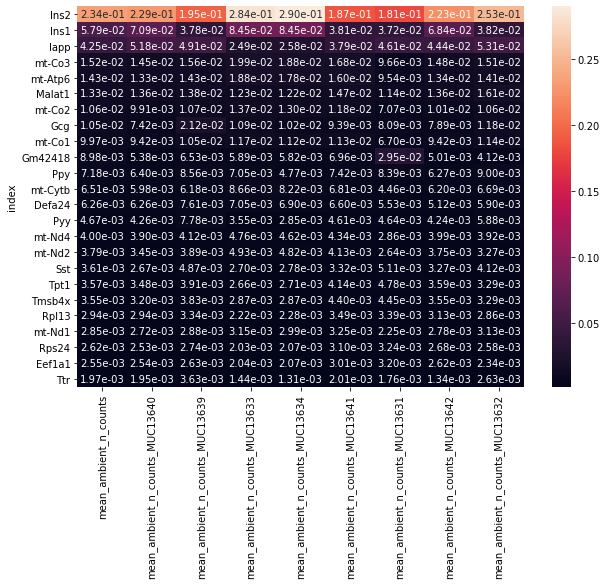

In [35]:
# Display ambient genes across samples
sb.heatmap(ambient_df.sort_values('mean_ambient_n_counts',ascending=False).iloc[:20,:],annot=True,fmt='.2e')

In [19]:
# Save ambient DF for top N genes
if SAVE:
    ambient_df.to_csv(shared_folder+"ambient_genes_topN_scores.tsv",sep='\t')

In [37]:
# Save genes with scaled mean ambient expression at least > 0.005 in any sample - 
# use the same genes for each sample so that further prrocessing (cell type annotation, embedding) can be done jointly
# !!! Check on heatmap that all such genes were included in the filtered 20 genes
ambient_genes_selection=list(ambient_df[(ambient_df>0.005).any(axis=1)].index)

print('Selected ambient genes:',ambient_genes_selection)
if SAVE:
    pickle.dump( ambient_genes_selection, open( shared_folder+"ambient_genes_selection.pkl", "wb" ) )

Selected ambient genes: ['mt-Co1', 'mt-Atp6', 'Ins1', 'Defa24', 'Gcg', 'Iapp', 'Sst', 'mt-Cytb', 'Ins2', 'Ppy', 'Malat1', 'Gm42418', 'mt-Co2', 'mt-Co3', 'Pyy']


In [ ]:
#### Proportion of ambience based on ambient threshold
#All calculations are based on removing ambient genes from single sample, except for the plot line 
#"N removed genes across samples" that represents N removed genes at threshold across all samples

In [20]:
# Calculate retained ambient proportion and sum(abs(ambient_mean_geneI-ambient_sample_geneI))
# for ambient gene removal thresholds. Ambient genes are removed per sample.
thresholds=list(1/np.logspace(1,18,num=300,base=2,dtype='int'))
ambient_diffs=pd.DataFrame(columns=adata_raw.obs.file.unique())
removed_genes=pd.DataFrame(columns=list(adata_raw.obs.file.unique())+['all'])
ambient_proportions=pd.DataFrame(columns=adata_raw.obs.file.unique())
for idx,threshold in enumerate(thresholds):
    ambient_df_sub=ambient_df[~(ambient_df>threshold).any(axis=1)]
    removed_genes.at[idx,'all']=adata_raw.shape[1]-ambient_df_sub.shape[0]
    for sample in adata_raw.obs.file.unique():
        ambient_df_sub=ambient_df[~(ambient_df['mean_ambient_n_counts_'+sample]>threshold)]
        removed_genes.at[idx,sample]=adata_raw.shape[1]-ambient_df_sub.shape[0]
        diff=abs(ambient_df_sub['mean_ambient_n_counts']-ambient_df_sub['mean_ambient_n_counts_'+sample]).sum()
        ambient_diffs.at[idx,sample]=diff
        ambient_proportions.at[idx,sample]=ambient_df_sub['mean_ambient_n_counts_'+sample].sum()

In [21]:
AMBIENT_THR=0.001

In [22]:
#Difference between mean and per sample ambient scores for retained genes
#and N removed genes across samples

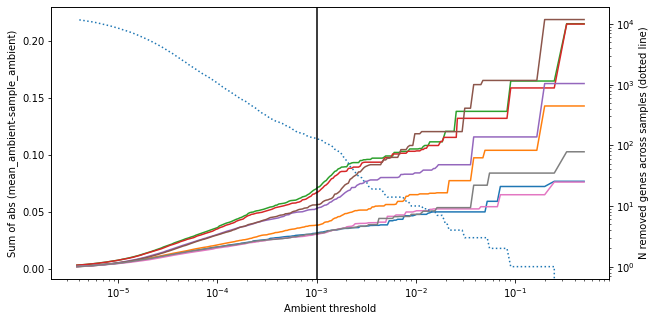

In [23]:
# Difference to average ambient scores for retained genes at each threshold
rcParams['figure.figsize']= (10,5)
fig,ax=plt.subplots()
ax2 = ax.twinx()  
for sample in adata_raw.obs.file.unique():
    ax.plot(thresholds,ambient_diffs[sample])
ax.set_xscale('log')
ax.set_ylabel('Sum of abs (mean_ambient-sample_ambient)')
ax.set_xlabel('Ambient threshold')
ax2.plot(thresholds,removed_genes['all'],linestyle='dotted')
ax2.set_yscale('log')
ax2.set_ylabel('N removed genes across samples (dotted line)')
plt.axvline(AMBIENT_THR,c='k')

In [ ]:
#Retained ambient proportion per sample
#and N removed genes across samples

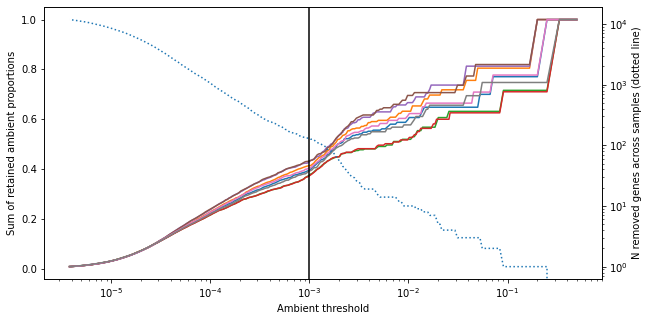

In [24]:
# Retained ambience per sample vs threshold
rcParams['figure.figsize']= (10,5)
fig,ax=plt.subplots()
for sample in adata_raw.obs.file.unique():
    ax.plot(thresholds,ambient_proportions[sample])
ax.set_xscale('log')
ax.set_ylabel('Sum of retained ambient proportions')
ax.set_xlabel('Ambient threshold')
ax2 = ax.twinx()  
ax2.plot(thresholds,removed_genes['all'],linestyle='dotted')
ax2.set_yscale('log')
ax2.set_ylabel('N removed genes across samples (dotted line)')
plt.axvline(AMBIENT_THR,c='k')

In [25]:
#N removed genes per sample

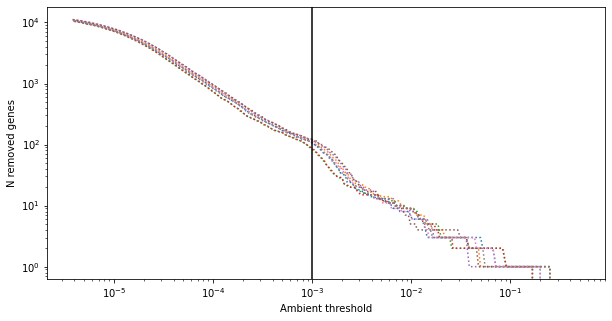

In [26]:
# N removed genes per sample
rcParams['figure.figsize']= (10,5)
fig,ax=plt.subplots()
for sample in adata_raw.obs.file.unique():
    ax.plot(thresholds,removed_genes[sample],linestyle='dotted')
ax.set_xscale('log')
ax.set_ylabel('N removed genes')
ax.set_xlabel('Ambient threshold')
ax.set_yscale('log')
plt.axvline(AMBIENT_THR,c='k')

In [27]:
#Removed ambience proportion divided by removed genes per sample

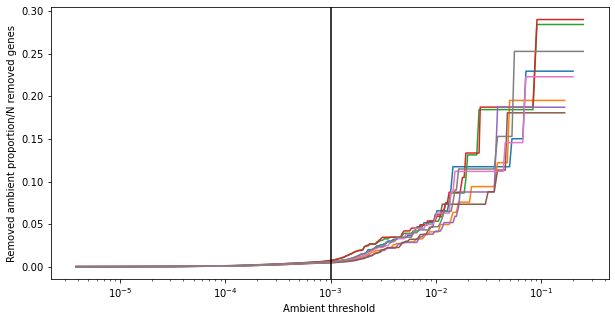

In [28]:
# Comparison of removed ambience vs N of removed genes per sample
rcParams['figure.figsize']= (10,5)
fig,ax=plt.subplots()
for sample in adata_raw.obs.file.unique():
    any_removed=np.array(removed_genes[sample])>0
    ax.plot(np.array(thresholds)[any_removed],((1-ambient_proportions[sample])/removed_genes[sample])[any_removed])
ax.set_xscale('log')
ax.set_ylabel('Removed ambient proportion/N removed genes')
ax.set_xlabel('Ambient threshold')
plt.axvline(AMBIENT_THR,c='k')

In [30]:
# Save genes with scaled mean ambient expression at least > threshold in any sample - 
# use the same genes for each sample so that further prrocessing (cell type annotation, embedding) can be done jointly
# !!! Check on heatmap that all such genes were included in the filtered 20 genes
ambient_genes_selection=list(ambient_df[(ambient_df>AMBIENT_THR).any(axis=1)].index)

print('N selected ambient genes:',len(ambient_genes_selection))
if SAVE:
    pickle.dump( ambient_genes_selection, open( shared_folder+"ambient_genes_selection_extended.pkl", "wb" ) )

N selected ambient genes: 129


In [39]:
del adata_raw

## QC (counts, genes, mt)

In [40]:
# Add other QC metrics

#adata.obs['n_counts'] = adata.X.sum(axis = 1)
#adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(axis = 1)

mt_gene_mask = np.flatnonzero([gene.startswith('mt-') for gene in adata.var_names])
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['mt_frac'] = np.sum(adata[:, mt_gene_mask].X, axis=1).A1/adata.obs['n_counts']

### QC on UMAP 
Data used for UMAP: Total count normalised data with log transformation and PC preprocessing. UMAP distances are based on correlation.

In [41]:
# Preprocess data for UMAP
adata_pp=adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6, exclude_highly_expressed=True)
sc.pp.log1p(adata_pp)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Gcg', 'Chgb', 'Cst3', 'Slpi', 'Tmsb4x', 'Cpb1', 'S100a6', 'S100a8', 'S100a9', 'Clca1', 'Ccl21a', 'Prdx1', 'Cela3b', 'Cela2a', 'Igfbp7', 'Jchain', 'Cxcl1', 'Cxcl13', 'Spp1', 'Actb', 'Cpa1', '1810009J06Rik', 'Gm2663', '2210010C04Rik', 'Try4', 'Try5', 'Prss3', 'Gm5771', 'Gm10334', 'Prss1', 'Prss2', 'Igkc', 'Reg3b', 'Reg2', 'Reg1', 'Gkn3', 'Mgp', 'Iapp', 'Apoe', 'Fcgbp', 'Sycn', 'Ftl1', 'Saa3', 'Hbb-bt', 'Hbb-bs', 'Zg16', 'Dmbt1', 'Ins2', 'Hsp90b1', 'Lyz2', 'Il22', 'Defa24', 'Ctrb1', 'Mcpt2', 'Clu', 'Tpt1', 'Mmp12', 'Camp', 'Ngp', 'Hba-a1', 'Hba-a2', 'Ccl2', 'Ccl8', 'Ccl5', 'Ccl4', 'Ppy', 'Pyy', 'H3f3b', 'Ctla2a', 'Gzma', 'Chga', 'Igha', 'Ighe', 'Ighg2c', 'Ighg2b', 'Ighg1', 'Ighg3', 'Ighd', 'Ighm', 'Cela1', 'Glycam1', 'Iglc1', 'Iglc3', 'Iglc2', 'Sst', 'Retnlg', 'Clps', 'Tff3', 'Tff2', 'Gm26917', 'Gm42418', 'Pgc', 'Ttr', 'Spink1', 'Cd74', 'Malat1', 'Neat1', 'Fth1', 

computing PCA with n_comps = 15
    finished (0:01:15)


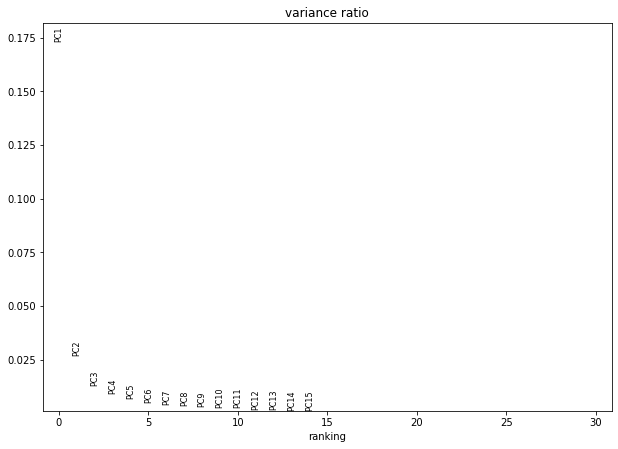

In [42]:
# Select number of PCs to use for UMAP
sc.pp.pca(adata_pp,n_comps=15,use_highly_variable =False)
sc.pl.pca_variance_ratio(adata_pp)

In [43]:
# Compute UMAP
sc.pp.neighbors(adata_pp, n_neighbors=15, n_pcs=6, metric='correlation')
sc.tl.umap(adata_pp)

computing neighbors
    using 'X_pca' with n_pcs = 6
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:25)
computing UMAP


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'

    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:31)


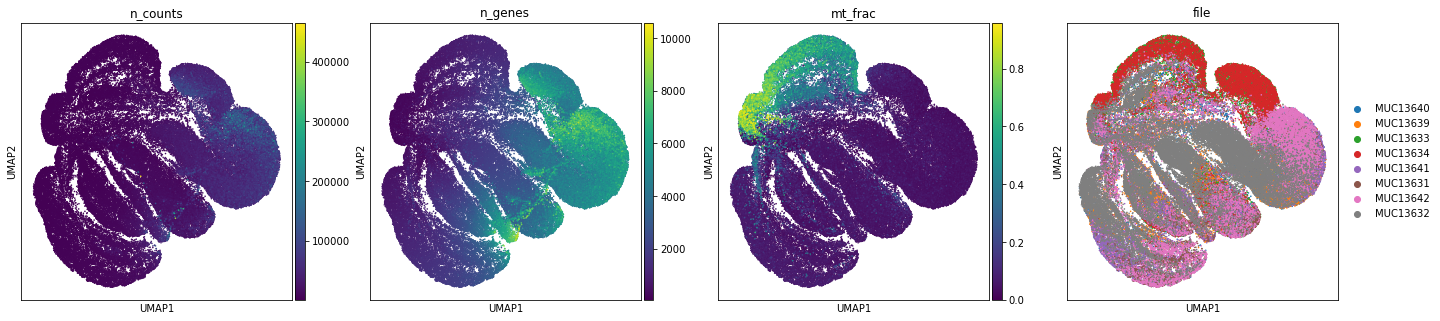

In [44]:
# Plot UMAP
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata_pp, color=['n_counts','n_genes','mt_frac','file'],size=10)

#C: Low n_genes and n_counts cells have high mt_frac and high n_counts cells have high n_genes. There is a subpopulation that has high n_genes but not high N_counts. Samples do not have evident batch effects.

### QC - select thresholds

Check:
- joint distribution of N genes, N counts, and mt fraction
- distribution of metrics across samples

In [45]:
#adata_temp=adata.copy()

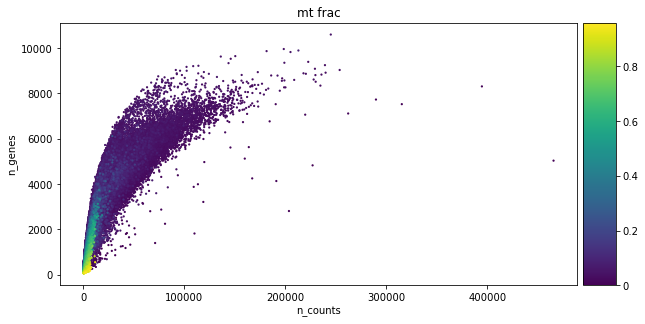

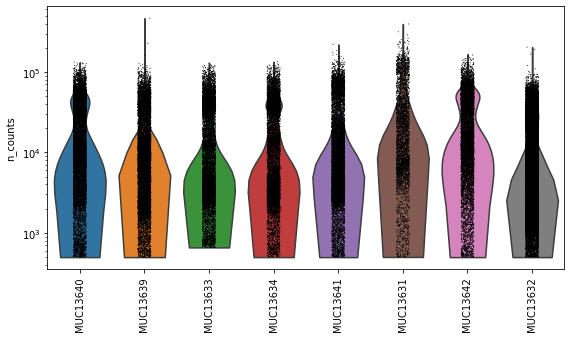

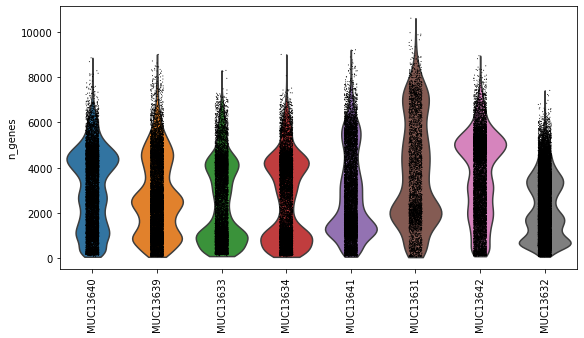

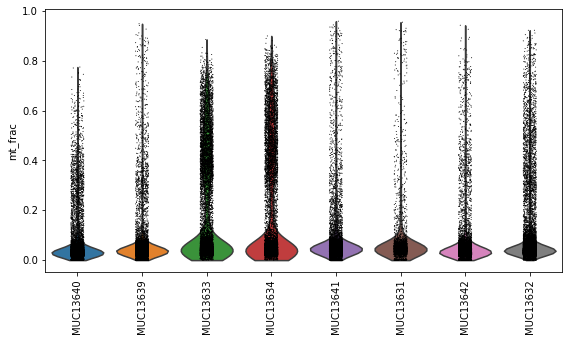

In [46]:
#Data quality summary plots
rcParams['figure.figsize']=(8,5)
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac', size=20)
sc.pl.violin(adata, ['n_counts'], groupby='file', size=1, log=True,rotation=90)
sc.pl.violin(adata, ['n_genes'], groupby='file', size=1, log=False,rotation=90)
sc.pl.violin(adata, ['mt_frac'], groupby='file', size=1, log=False,rotation=90)

N counts:

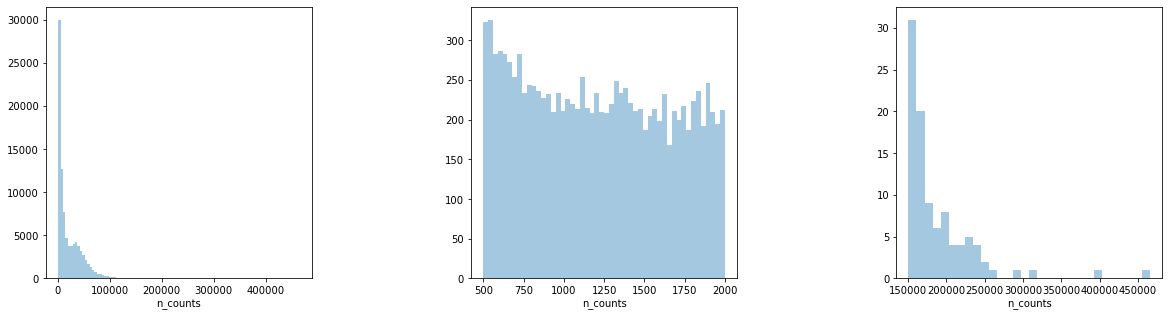

In [47]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p3 = sb.distplot(adata.obs['n_counts'], 
                 kde=False, 
                 ax=fig.add_subplot(fig_ind[0]), bins=100)
#p3.set_xscale('log')
p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<2000], 
                 kde=False, bins=50, 
                 ax=fig.add_subplot(fig_ind[1]))
#p4.set_xscale('log')
p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>150000], 
                 kde=False, bins=30, 
                 ax=fig.add_subplot(fig_ind[2]))
plt.show()

N genes:

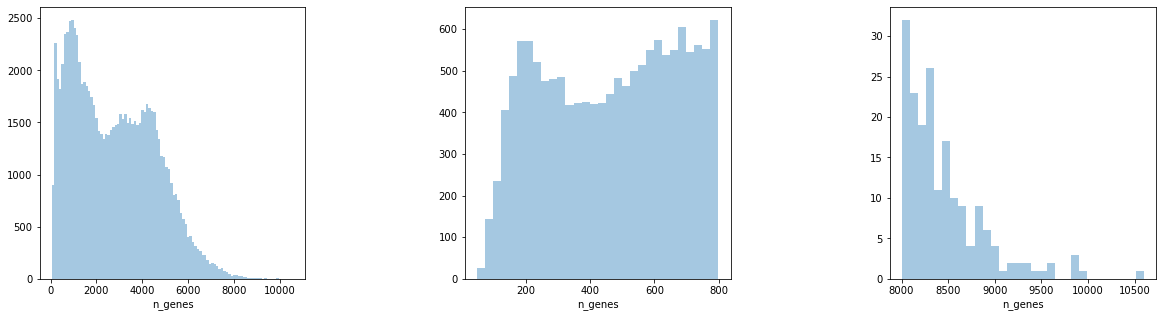

In [52]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6) #create a grid for subplots

p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=100, ax=fig.add_subplot(fig_ind[0]))

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<800], 
                 kde=False, bins=30, ax=fig.add_subplot(fig_ind[1]))
p8 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']>8000], 
                 kde=False, bins=30, ax=fig.add_subplot(fig_ind[2]))
plt.show()

MT fraction:

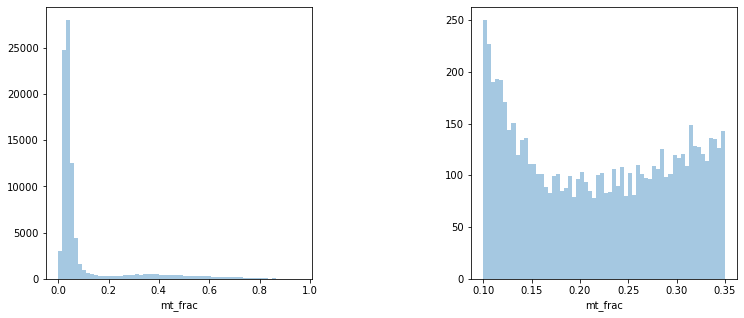

In [54]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p8 = sb.distplot(adata.obs['mt_frac'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p9 = sb.distplot(adata.obs['mt_frac'][adata.obs['mt_frac'].between(0.1, 0.35)], 
                 kde=False, bins=60, ax=fig.add_subplot(fig_ind[1]))
plt.show()

For cells that have too low/high metrics show location on UMAP.

In [50]:
def assign_high_low(adata,obs_col,low,high):
    """
    Add low/high annotation to each cell for a metric. 
    Add obs column specifying if cell has ok/low/high value (categories ordered in this order) and uns color map - 
    gray for ok, blue for low, red for high.
    New obs columns is named obs_col_filter and colourmap is named obs_col_filter_colors.
    :param adata: anndata object that contains column with metric to be filtered and to which filter result column
    and colur map are added
    :param obs_col: obs column on which to perform filtering
    :param low: low - cells that have obs_col value < low are assigned 'low'
    :param high: high - cells that have obs_col value > high are assigned 'high'
    """
    cell_type=[]
    for val in adata.obs[obs_col]:
        if val>high:
            cell_type.append('high')
        elif val<low:
            cell_type.append('low')
        else:
            cell_type.append('ok')
    adata.obs[obs_col+'_filter']=cell_type
    adata.obs[obs_col+'_filter']=adata.obs[obs_col+'_filter'].astype('category')
    # So that low and high are plotted on top
    adata.obs[obs_col+'_filter'].cat.reorder_categories(
        [category for category in ['ok','low','high'] if category in adata.obs[obs_col+'_filter'].cat.categories], inplace=True)
    type_col={'high':'#e62e0e','low':'#02c6ed','ok':'#a8a8a8'}
    col_list=[]
    for filter_type in adata.obs[obs_col+'_filter'].cat.categories:
        col_list.append(type_col[filter_type])
    adata.uns[obs_col+'_filter_colors']=col_list

ok      86579
low      3561
high        4
Name: n_counts_filter, dtype: int64


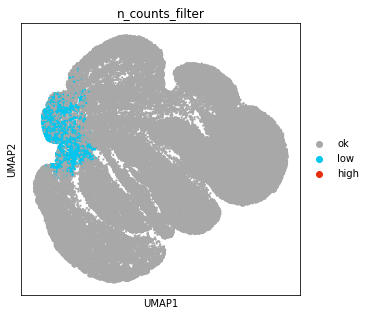

In [51]:
param='n_counts'
rcParams['figure.figsize']=(5,5)
COUNTS_THR_MIN=900
COUNTS_THR_MAX=270000
assign_high_low(adata=adata,obs_col=param,low=COUNTS_THR_MIN,high=COUNTS_THR_MAX)
print(adata.obs[param+'_filter'].value_counts())
adata_pp.obs[param+'_filter']=adata.obs[param+'_filter']
adata_pp.uns[param+'_filter_colors']=adata.uns[param+'_filter_colors']
sc.pl.umap(adata_pp, color=[param+'_filter'],size=20)

ok      85309
low      4830
high        5
Name: n_genes_filter, dtype: int64


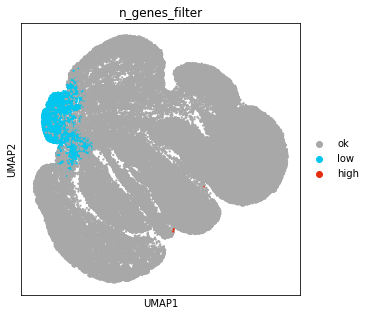

In [53]:
param='n_genes'
rcParams['figure.figsize']=(5,5)
GENES_THR_MIN=350
GENES_THR_MAX=9700
assign_high_low(adata=adata,obs_col=param,low=GENES_THR_MIN,high=GENES_THR_MAX)
print(adata.obs[param+'_filter'].value_counts())
adata_pp.obs[param+'_filter']=adata.obs[param+'_filter']
adata_pp.uns[param+'_filter_colors']=adata.uns[param+'_filter_colors']
sc.pl.umap(adata_pp, color=[param+'_filter'],size=20)

ok      76901
high    13243
Name: mt_frac_filter, dtype: int64


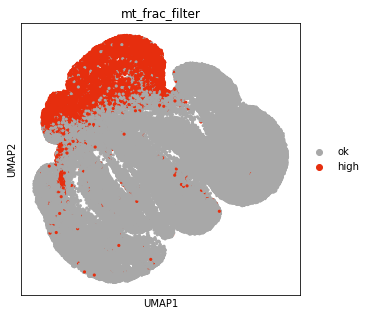

In [57]:
param='mt_frac'
MT_THR=0.17
rcParams['figure.figsize']=(5,5)
assign_high_low(adata=adata,obs_col=param,low=-1,high=MT_THR)
print(adata.obs[param+'_filter'].value_counts())
adata_pp.obs[param+'_filter']=adata.obs[param+'_filter']
adata_pp.uns[param+'_filter_colors']=adata.uns[param+'_filter_colors']
sc.pl.umap(adata_pp, color=[param+'_filter'],size=40)

#C: High N cells and N genes cells will be filtered out.

N cells in which a gene is expressed:

In [58]:
adata.var['n_cells']=(adata.X > 0).sum(axis = 0).T

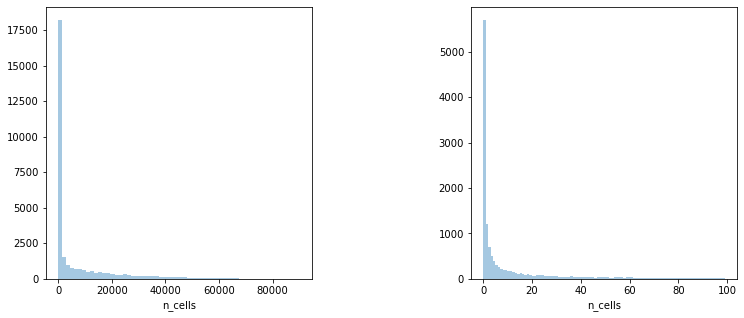

<AxesSubplot:xlabel='n_cells'>

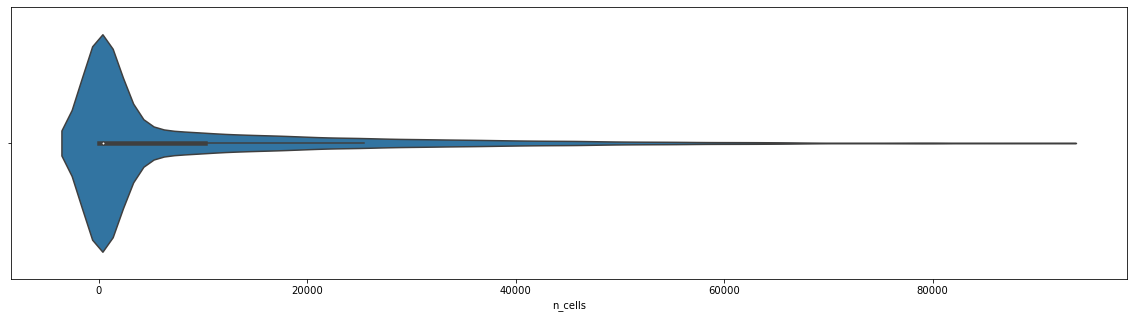

In [59]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6) #create a grid for subplots

p6 = sb.distplot(adata.var['n_cells'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p8 = sb.distplot(adata.var['n_cells'][adata.var['n_cells']<100], 
                 kde=False, bins=100, ax=fig.add_subplot(fig_ind[1]))
plt.show()
sb.violinplot(adata.var['n_cells'] )

Filter out genes and cells

In [60]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = COUNTS_THR_MIN)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, max_counts = COUNTS_THR_MAX)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] <= MT_THR]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = GENES_THR_MIN)
print('Number of cells after min gene filter: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, max_genes = GENES_THR_MAX)
print('Number of cells after max gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 90144
filtered out 3561 cells that have less than 900 counts
Number of cells after min count filter: 86583
filtered out 4 cells that have more than 270000 counts
Number of cells after max count filter: 86579
Number of cells after MT filter: 74567
filtered out 509 cells that have less than 350 genes expressed


Trying to set attribute `.obs` of view, copying.


Number of cells after min gene filter: 74058
filtered out 5 cells that have more than 9700 genes expressed
Number of cells after max gene filter: 74053


In [61]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

CELLS_THR_MIN=20
# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=CELLS_THR_MIN)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 31125
filtered out 10980 genes that are detected in less than 20 cells
Number of genes after cell filter: 20145


Subset genes so that ref genes are not removed - UNUSED - insetad of the above cell

## Doublet filtering

Perform doublet filtering with Scrublet per sample.

In [62]:
adata.obs['doublet_score']=np.zeros(adata.shape[0])
adata.obs['doublet']=np.zeros(adata.shape[0])

# filtering/preprocessing parameters:
min_counts = 3
min_cells = 3
vscore_percentile = 85
n_pc = 30

# doublet detector parameters:
expected_doublet_rate = 0.05 
sim_doublet_ratio = 2
n_neighbors = None #If `None`, this is set to round(0.5 * sqrt(n_cells))

# Detect doublets per sample
for batch in adata.obs['file'].cat.categories:
    idx = adata.obs[adata.obs['file']==batch].index
    print(batch, 'N cells:',idx.shape[0])
    scrub = scr.Scrublet(counts_matrix = adata[idx,:].X,  
                     n_neighbors = n_neighbors,
                     sim_doublet_ratio = sim_doublet_ratio,
                     expected_doublet_rate = expected_doublet_rate)
    doublet_scores, predicted_doublets = scrub.scrub_doublets( 
                    min_counts = min_counts, 
                    min_cells = min_cells, 
                    n_prin_comps = n_pc,
                    use_approx_neighbors = True, 
                    get_doublet_neighbor_parents = False)
    adata.obs.loc[idx,'doublet_score'] = doublet_scores
    adata.obs.loc[idx,'doublet'] = predicted_doublets

MUC13640 N cells: 9390
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.62
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%
Elapsed time: 11.2 seconds
MUC13639 N cells: 9961
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.18
Detected doublet rate = 5.6%
Estimated detectable doublet fraction = 46.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 12.0%
Elapsed time: 11.5 seconds
MUC13633 N cells: 5807
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.26
Detected doublet rate = 2.7%
Estimated detectable doublet fraction = 30.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated 

Distribution of doublet scores

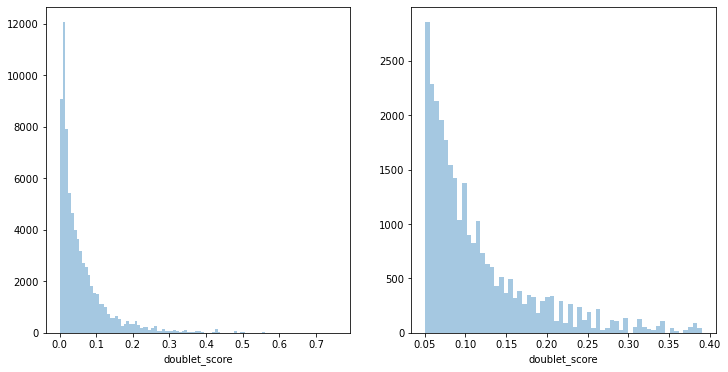

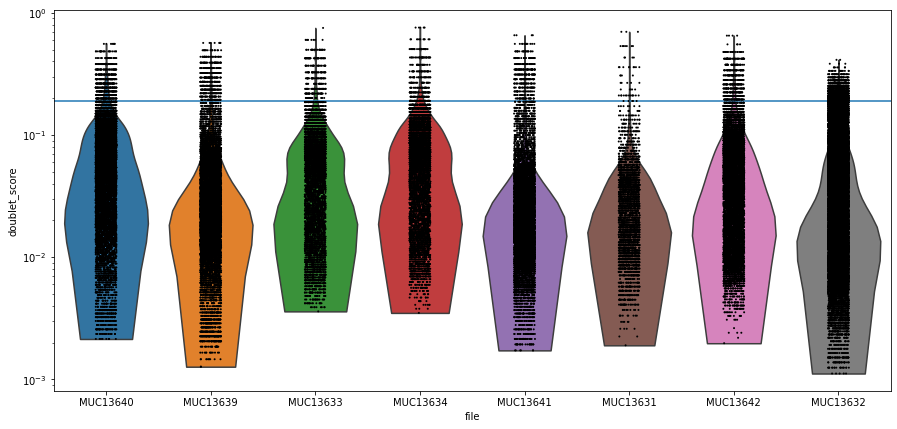

In [73]:
rcParams['figure.figsize']=(12,6)
fig,ax=plt.subplots(1,2)
sb.distplot(adata.obs['doublet_score'], bins=100, kde=False,ax=ax[0])
sb.distplot(adata[adata.obs.doublet_score.between(0.05,0.4)].obs['doublet_score'], bins=60, kde=False,ax=ax[1])
plt.show()

rcParams['figure.figsize']=(15,7)
fig,ax=plt.subplots()
sc.pl.violin(adata, 'doublet_score',
                  groupby='file',
                  size=2, log=True, cut=0,ax=ax,show=False)
DOUBLET_THR=0.19
ax.axhline(DOUBLET_THR)
plt.show()

Trying to set attribute `.obs` of view, copying.


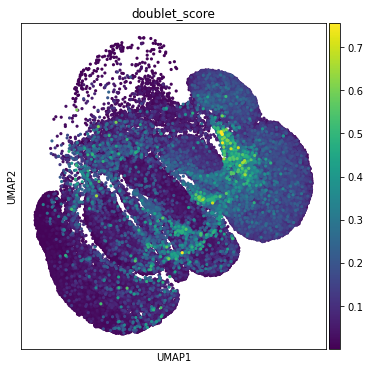

ok      69745
high     4308
Name: doublet_score_filter, dtype: int64


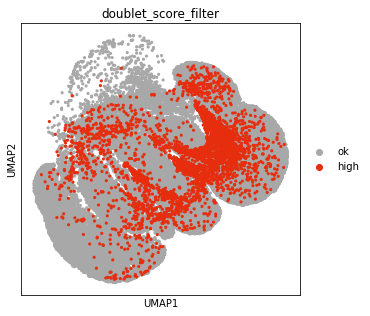

In [74]:
# Remove cells from adata_pp that were removed before from adata
adata_pp=adata_pp[adata.obs.index]

# Plot doublet score and filtering threshold on UMAP
rcParams['figure.figsize']=(6,6)
adata_pp.obs['doublet_score']=adata.obs['doublet_score']
sc.pl.umap(adata_pp, color=['doublet_score'],size=40)
param='doublet_score'
rcParams['figure.figsize']=(5,5)
assign_high_low(adata=adata,obs_col=param,low=-np.inf,high=DOUBLET_THR)
print(adata.obs[param+'_filter'].value_counts())
adata_pp.obs[param+'_filter']=adata.obs[param+'_filter']
adata_pp.uns[param+'_filter_colors']=adata.uns[param+'_filter_colors']
sc.pl.umap(adata_pp[adata_pp.obs[param+'_filter'].sort_values().index], color=[param+'_filter'],size=40)

In [75]:
print('Number of cells before doublet filter: {:d}'.format(adata.n_obs))
idx_filt = adata.obs['doublet_score']<=DOUBLET_THR

adata = adata[idx_filt].copy()
print('Number of cells after doublet filter: {:d}'.format(adata.n_obs))

Number of cells before doublet filter: 74053
Number of cells after doublet filter: 69745


## Summary after QC

In [76]:
# Summary statistics per file/batch
df = adata.obs[['n_genes','n_counts','file']]
df_all = pd.DataFrame(index=df['file'].unique())

df_all['mean_genes']=df.groupby(by='file')['n_genes'].mean()
df_all['median_genes']=df.groupby(by='file')['n_genes'].median()
df_all['mean_counts']=df.groupby(by='file')['n_counts'].mean()
df_all['median_counts']=df.groupby(by='file')['n_counts'].median()
df_all['n_cells']=df['file'].value_counts()
df_all.astype('float').round(1)

,mean_genes,median_genes,mean_counts,median_counts,n_cells
MUC13640,3482.9,3790.0,28955.4,25494.0,8787.0
MUC13639,2964.8,2672.0,19659.3,11298.5,9442.0
MUC13633,3602.4,3805.5,31658.1,31740.0,5522.0
MUC13634,3730.9,3946.0,33155.5,34101.0,5633.0
MUC13641,3022.7,2587.5,22003.2,9288.0,8788.0
MUC13631,4085.0,3842.0,38164.8,19555.0,3211.0
MUC13642,3930.7,4304.0,32711.9,27758.0,8439.0
MUC13632,2391.6,2177.0,16406.1,9335.0,19923.0


In [77]:
# Check that all filters were used properly - the min/max values are as expected
print('N counts range:',round(adata.obs['n_counts'].min(),1),'-',round(adata.obs['n_counts'].max(),1))
print('N genes range:',adata.obs['n_genes'].min(),'-',adata.obs['n_genes'].max())
print('Mt fraction range:',"{:.3e}".format(adata.obs['mt_frac'].min()),'-',"{:.3e}".format(adata.obs['mt_frac'].max()))
print('Doublet score range:',"{:.3e}".format(adata.obs['doublet_score'].min()),'-',"{:.3e}".format(adata.obs['doublet_score'].max()))
print('N cellls expressing a gene range:',adata.var['n_cells'].min(),'-',adata.var['n_cells'].max())

N counts range: 900.0 - 262387.0
N genes range: 350 - 9644
Mt fraction range: 0.000e+00 - 1.700e-01
Doublet score range: 1.116e-03 - 1.896e-01
N cellls expressing a gene range: 20 - 74051


## Save QC data

In [78]:
# Save QC data
if SAVE:
    #adata.write(shared_folder+'data_QC.h5ad')
    h.save_h5ad(adata=adata,file=shared_folder+'data_QC.h5ad',unique_id2=UID2)
    #pickle.dump( adata, open( shared_folder+"data_QC.pkl", "wb" ) )

## Normalisation and log-scaling

In [79]:
# Load QC data
#adata=sc.read_h5ad(shared_folder+'data_QC.h5ad')
#adata=pickle.load( open( shared_folder+"data_QC.pkl", "rb" ) )
adata=h.open_h5ad(file=shared_folder+'data_QC.h5ad',unique_id2=UID2)

In [80]:
# Remove ambient genes from analysis - required if joint normalisation is performed
print('Number of genes: {:d}'.format(adata.var.shape[0]))
ambient_genes=pickle.load( open( shared_folder+"ambient_genes_selection.pkl", "rb" ) )
# Save all genes to raw
adata.raw=adata.copy()
adata = adata[:,np.invert(np.in1d(adata.var_names, ambient_genes))].copy()
print('Number of genes after ambient removal: {:d}'.format(adata.var.shape[0]))

Number of genes: 20145
Number of genes after ambient removal: 20130


In [81]:
adata.layers['counts'] = adata.X.copy()

In [82]:
# Data for: clustering for scran normalization in clusters and visualisation of samples on UMAP
# Make new adata_pp object that also has removed unexpressed genes 
# The adata_pp is pre-processed with normalisation to N total counts, log transformation and PC dimeni
adata_pp=adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6, exclude_highly_expressed=True)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Scg2', 'Rgs5', 'Hspa5', 'Chgb', 'Cst3', 'Slpi', 'Tmsb4x', 'Fabp4', 'Cpb1', 'S100a6', 'S100a8', 'S100a9', 'Clca1', 'Ccl21a', 'Jun', 'Prdx1', 'Cela3b', 'Cela2a', 'Igfbp7', 'Jchain', 'Cxcl1', 'Cxcl2', 'Cxcl10', 'Cxcl13', 'Spp1', 'Actb', 'Cpa1', '1810009J06Rik', 'Gm2663', '2210010C04Rik', 'Try4', 'Try5', 'Prss3', 'Gm5771', 'Gm10334', 'Prss1', 'Prss2', 'Igkc', 'Reg3b', 'Reg2', 'Reg1', 'Gkn3', 'Mgp', 'Apoe', 'Fcgbp', 'Sycn', 'Ftl1', 'Saa3', 'Hbb-bt', 'Hbb-bs', 'Zg16', 'Hsp90b1', 'Lyz2', 'Il22', 'Mt1', 'Ctrb1', 'Mcpt2', 'Clu', 'Camp', 'Ngp', 'Cck', 'Hba-a1', 'Hba-a2', 'Ccl2', 'Ccl8', 'Ccl5', 'Ccl4', 'Wfdc18', 'H3f3b', 'Ctla2a', 'Gzma', 'Chga', 'Meg3', 'Igha', 'Ighe', 'Ighg2c', 'Ighg2b', 'Ighg1', 'Ighg3', 'Ighm', 'Cela1', 'Glycam1', 'Iglc1', 'Iglc3', 'Iglc2', 'Retnlg', 'Clps', 'Tff3', 'Tff2', 'H2-Eb1', 'Gm26917', 'AY036118', 'Pgc', 'Ttr', 'Spink1', 'Cd74', 'Neat1', 'Ft

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities


Cluster cells for scran normalisation

In [83]:
# Perform clustering
sc.tl.leiden(adata_pp, key_added='groups', resolution=1)
print('N clusters:',adata_pp.obs['groups'].unique().shape[0])

running Leiden clustering


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']


    finished: found 35 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:22)
N clusters: 35


Compare samples on UMAP before scran normalisation to decide if it can be peroformed jointly or not.

In [84]:
# Calculate UMAP
sc.tl.umap(adata_pp)

computing UMAP


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:15)


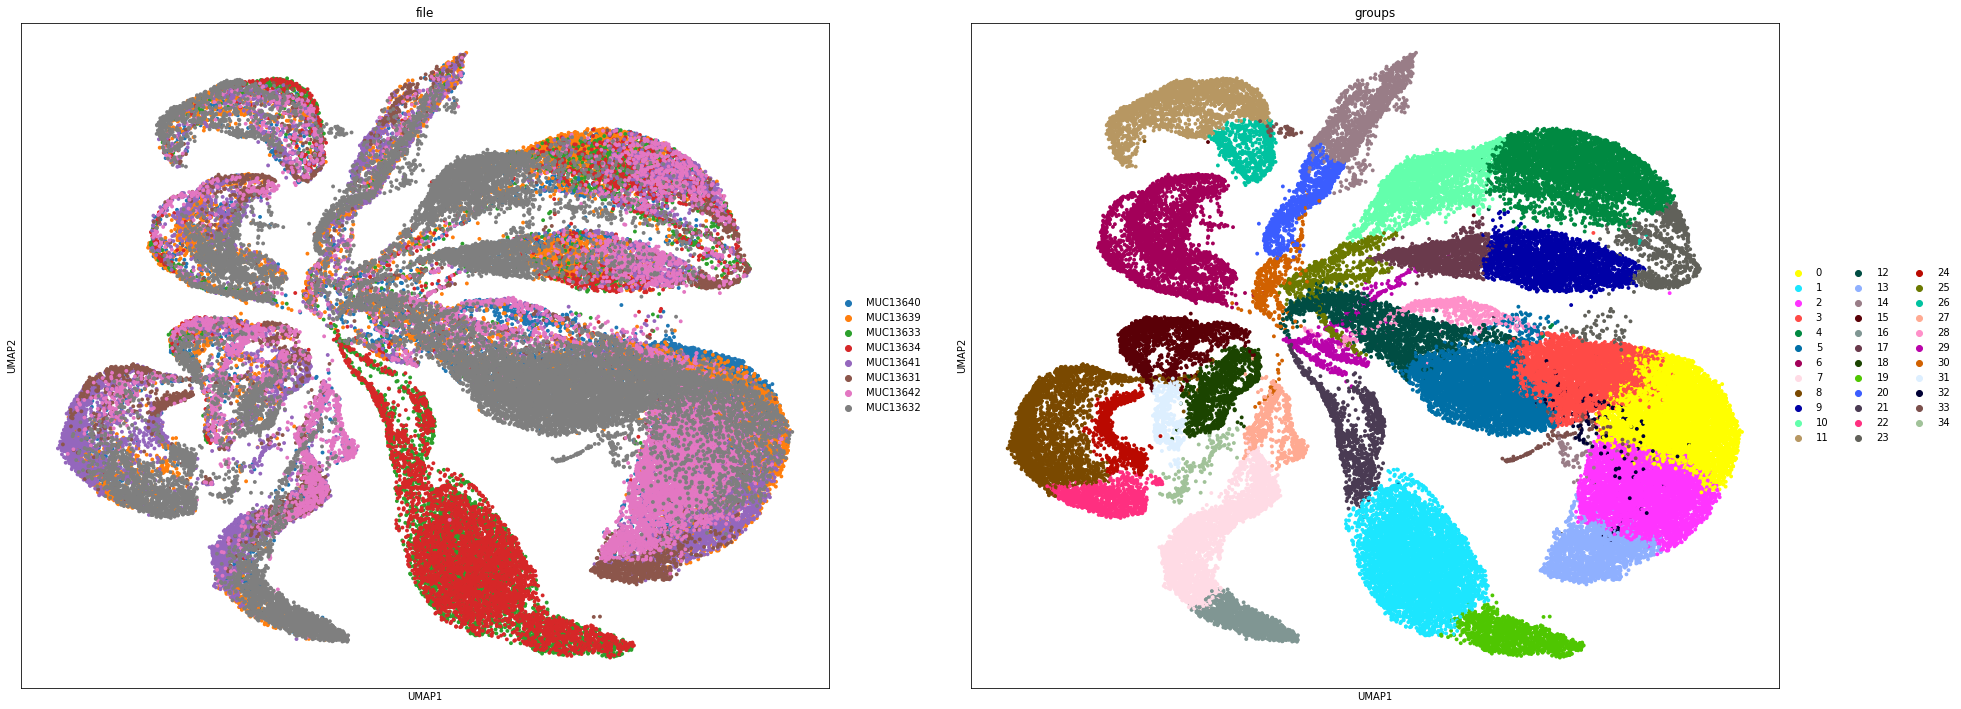

In [85]:
# Plot UMAP
rcParams['figure.figsize']=(15,12)
sc.pl.umap(adata_pp, color=['file','groups'],size=60)

Joint Scran normalisation

In [86]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [87]:
%%R -i data_mat -i input_groups -o size_factors
size_factors =  calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1,BPPARAM=MulticoreParam(workers = 8))

Distribution of size factors

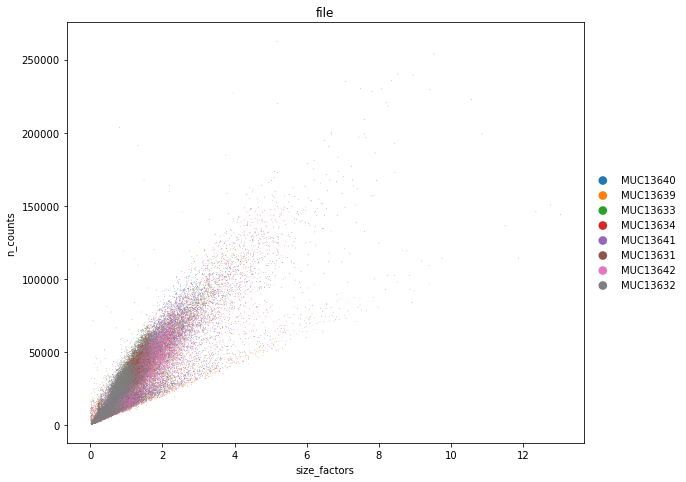

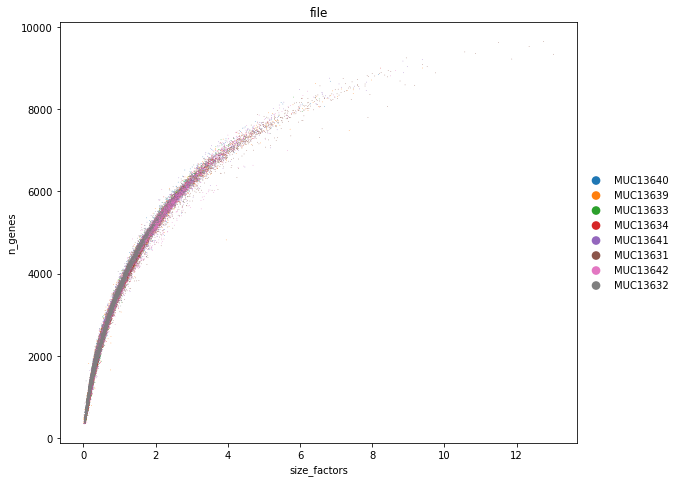

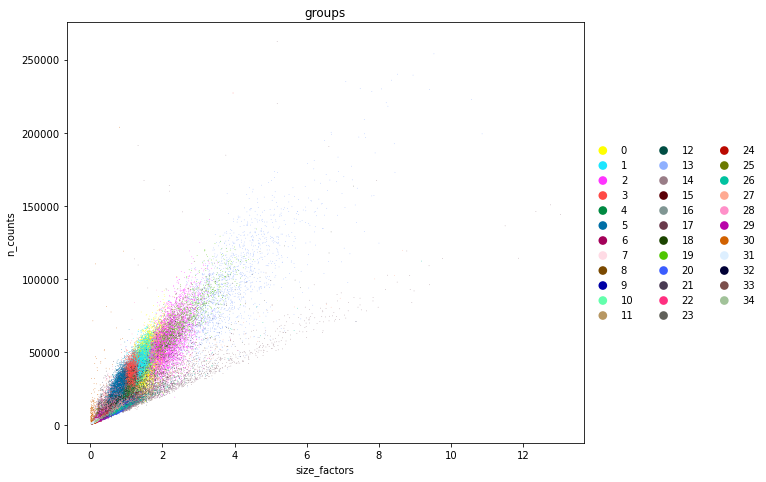

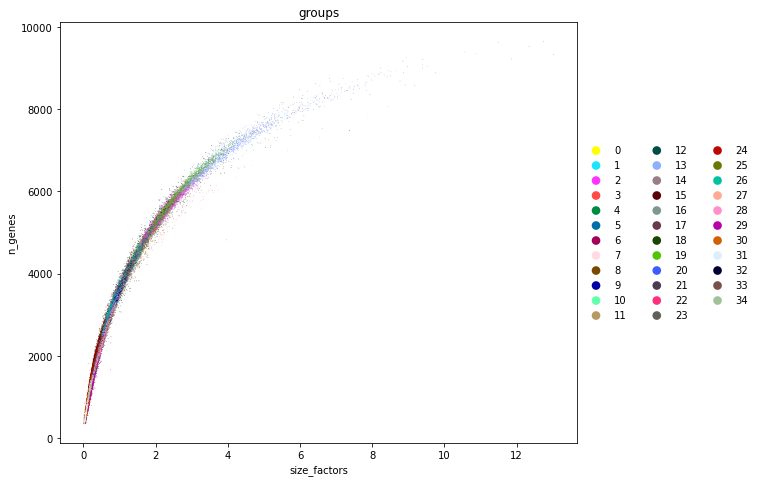

Distribution of size factors


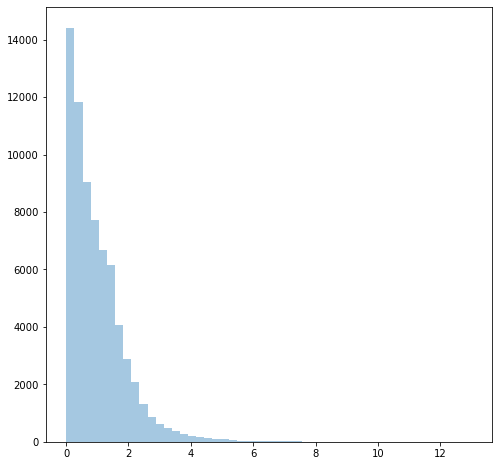

In [88]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors
adata_pp.obs['size_factors'] = size_factors

rcParams['figure.figsize']=(8,8)
sc.pl.scatter(adata, 'size_factors', 'n_counts', color='file')
sc.pl.scatter(adata, 'size_factors', 'n_genes', color='file')

#let us visualise how size factors differ across clusters
rcParams['figure.figsize']=(8,8)
#Use adata_pp here as it has obs 'group' - the n_genes and n_counts were copied from andata (counts/not normalised)
sc.pl.scatter(adata_pp, 'size_factors', 'n_counts', color='groups')
sc.pl.scatter(adata_pp, 'size_factors', 'n_genes', color='groups')

print('Distribution of size factors')
sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [89]:
# Scale data with size factors
adata.X /= adata.obs['size_factors'].values[:,None] # This reshapes the size-factors array
sc.pp.log1p(adata)
adata.X = np.asarray(adata.X)

In [90]:
del adata_pp

## Highly variable genes

Compare Seurat and CellRanger HVGs.

In [91]:
##hvg_vars=['highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection']

## Seurat
#sc.pp.highly_variable_genes(adata, flavor='seurat', batch_key='file')
#n_hvg_seurat=np.sum(adata.var['highly_variable'])
#print('\n','Number of highly variable genes: {:d}'.format(n_hvg_seurat))
##hvg_seurat=adata.var[hvg_vars]
#rcParams['figure.figsize']=(10,5)
#sc.pl.highly_variable_genes(adata)

## Same number of genes in CellRanger
#sc.pp.highly_variable_genes(adata, flavor='cell_ranger', batch_key='file',n_top_genes =n_hvg_seurat)
#print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))
##hvg_cellranger=adata.var[hvg_vars]
#rcParams['figure.figsize']=(10,5)
#sc.pl.highly_variable_genes(adata)

#C: Decided for CellRanger method.

extracting highly variable genes
    finished (0:00:25)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 2000


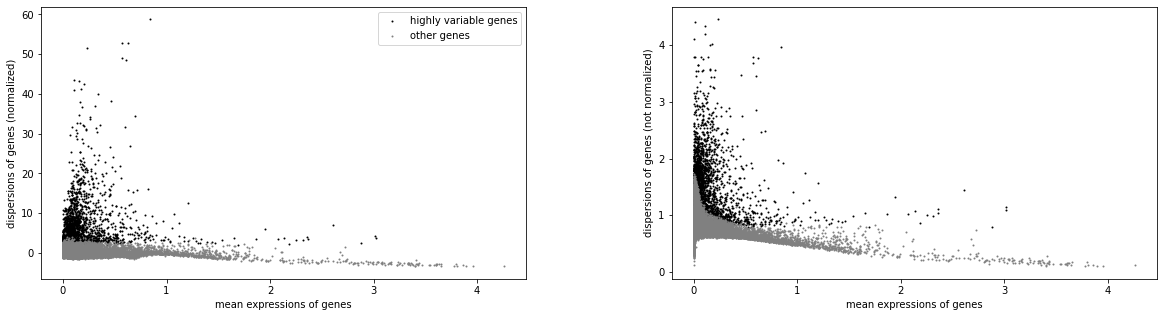

In [92]:
# Compute and plot HVG
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', batch_key='file',n_top_genes =2000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))
rcParams['figure.figsize']=(10,5)
sc.pl.highly_variable_genes(adata)

In [93]:
adata

AnnData object with n_obs × n_vars = 69745 × 20130
    obs: 'file', 'n_counts', 'n_genes', 'mt_frac', 'n_counts_filter', 'n_genes_filter', 'mt_frac_filter', 'doublet_score', 'doublet', 'doublet_score_filter', 'size_factors'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'doublet_score_filter_colors', 'file_colors', 'mt_frac_filter_colors', 'n_counts_filter_colors', 'n_genes_filter_colors', 'log1p'
    layers: 'counts'

## Save normalised data

In [94]:
# Used due to problems with saving h5ad
#pickle.dump( adata, open( shared_folder+"data_normalised.pkl", "wb" ) )

In [95]:
if SAVE:
    #adata.write(shared_folder+"data_normalised.pkl")
    h.save_h5ad(adata=adata, file=shared_folder+"data_normalised.h5ad",unique_id2=UID2)

In [20]:
#adata_temp=adata.copy()
#adata=adata_temp.copy()

In [21]:
#adata_temp.write('/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/salinno_project/rev4/scanpy_AnnData/data_processed_temp.h5ad')